In [28]:
from skimage import io
import dlib
import numpy as np
import os
import re
import skimage.transform as tr
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.core.display import display
from skimage.transform import resize
import pandas as pd
import urllib
import httplib2
import urllib.request


# Dataset downloading


[SoF dataset](https://www.sites.google.com/view/sof-dataset)
[YouTube Faces DB](https://www.cs.tau.ac.il/~wolf/ytfaces/)
[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)


In [ ]:
#
# saint george download
#
% pdb
georges_path = 'saint george images/georges'
non_georges_path = 'saint george images/non georges'

georges_url = 'saint george images/georges/georges.csv'
non_georges_url = 'saint george images/non georges/non_georges.csv'

georges_df = pd.read_csv(georges_url)
non_georges_df = pd.read_csv(non_georges_url)

for i, url in enumerate(georges_df.values):
    h = httplib2.Http('.cache')
    response, content = h.request(url[0])
    out = open(georges_path + '/' + str(i) + '.jpg', "wb")
    out.write(content)
    out.close()

for i, url in enumerate(non_georges_df.values):
    h = httplib2.Http('.cache')
    response, content = h.request(url[0])
    out = open(non_georges_path + '/' + str(i) + '.jpg', "wb")
    out.write(content)
    out.close()



## Resize images
If there is no necessity in the selection of the face, we can just resize images

In [ ]:
def resize_images(path, new_path, new_shape):
    folder_names = os.listdir(path)
    os.mkdir(new_path)

    for name in folder_names:
        os.mkdir(new_path + '/' + name)

    for folder in folder_names:
        images_names = os.listdir(path + '/' + folder)
        for image_name in images_names:
            image = io.imread(path + '/' + folder + '/' + image_name)
            resized_image = resize(image, new_shape)
            io.imsave(new_path + '/' + folder + '/' + image_name, resized_image, check_contrast=False)


In [ ]:
path = 'saint george images'
new_path = 'saint georges dataset'
shape = (128, 128, 3)
#resize_images(path,new_path,shape)

# Second step - face highlighting

[Main approach]( https://habr.com/ru/post/317798/)

### Read computed weights

In [29]:
face_template_path = 'preprocess weights/face_template.npy'
dlib_predictor_path = "preprocess weights/shape_predictor_68_face_landmarks.dat"

### Find main points of the face 

It is possible as dlib detector is pre-trained to find face points. It works on segmentation

In [30]:
path_me = "display images/me.jpg"
image = io.imread(path_me)

face_template = np.load(face_template_path)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(dlib_predictor_path)

face_rects = list(detector(image, 1))
face_rect = face_rects[0]

points = predictor(image, face_rect)
landmarks = np.array(list(map(lambda p: [p.x, p.y], points.parts())))

### Lets look where points are located

In [35]:
photo = Image.open(path_me)
pix = photo.load()
draw = ImageDraw.Draw(photo)
N = 1

for point in landmarks:
    draw.ellipse(((point[0] - N, point[1] - N), (point[0] + N, point[1] + N)), fill=(0, 139, 139))

plt.figure(figsize=(7, 7))
#plt.imshow(photo)

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

### Choose 3 main points

Now we choose 3 main point on the image. It's not difficult as we know indeces of those points. Then to use Affine transformatiom need to choose 3 points, where the image would be wrapped

In [5]:
INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
proper_landmarks = 227 * face_template[INNER_EYES_AND_BOTTOM_LIP]
current_landmarks = landmarks[INNER_EYES_AND_BOTTOM_LIP]

### Draw 3 main point on the face

In [6]:
photo = Image.open(path_me)
pix = photo.load()
draw = ImageDraw.Draw(photo)
for point in current_landmarks:
    draw.ellipse(((point[0] - N, point[1] - N), (point[0] + N, point[1] + N)), fill=(255, 0, 0))
plt.figure(figsize=(7, 7))
#plt.imshow(photo)

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

### Mathematical view

The Affine transformation equetion consists of 2 matrices of points and T - transformation. $X^1, Y^1$ are points on original image and $X^0, Y^0$ are points on new, wrapped image

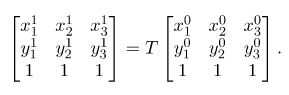

In [7]:
path_matrix = "display images/matrix.jpg"
image_matrix = Image.open(path_matrix)
display(image_matrix)

### Affine transform

In [8]:
size = 256
A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
T = np.linalg.solve(A, B).T

wrapped = tr.warp(
    image,
    tr.AffineTransform(T).inverse,
    output_shape=(size, size),
    mode='constant',
    cval=0,
    preserve_range=True
)
im = Image.fromarray(wrapped.astype(np.uint8))
#display(im)

## Bring together all methods


In [57]:
face_template_path = 'preprocess weights/face_template.npy'
dlib_predictor_path = "preprocess weights/shape_predictor_68_face_landmarks.dat"

class Transformer():

    def __init__(self, face_template_path, dlib_predictor_path):
        self.face_template = np.load(face_template_path)
        self.predictor = dlib.shape_predictor(dlib_predictor_path)
        self.detector = dlib.get_frontal_face_detector()
        self.INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]

    def crop_face(self, image, size=(128, 128)):

        face_rects = list(self.detector(image, 1))
        if len(face_rects) == 1:
            face_rect = face_rects[0]

            points = self.predictor(image, face_rect)
            landmarks = np.array(list(map(lambda p: [p.x, p.y], points.parts())))

            proper_landmarks = size * self.face_template[self.INNER_EYES_AND_BOTTOM_LIP]
            current_landmarks = landmarks[self.INNER_EYES_AND_BOTTOM_LIP]

            A = np.hstack([current_landmarks, np.ones((3, 1))]).astype(np.float64)
            B = np.hstack([proper_landmarks, np.ones((3, 1))]).astype(np.float64)
            T = np.linalg.solve(A, B).T

            wrapped = tr.warp(
                image,
                tr.AffineTransform(T).inverse,
                output_shape=size,
                mode='constant',
                cval=0,
                preserve_range=True
            )

            return wrapped.astype(np.uint8)
        else:
            return None

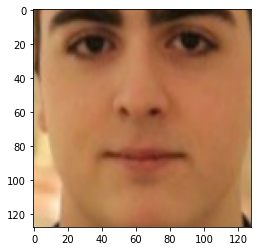

In [60]:
transformer = Transformer(face_template_path,dlib_predictor_path)
img = io.imread('display images/me.jpg')
res = transformer.crop_face(img,size=(128,128))
plt.imshow(res)


## Sof faces crop

In [1]:
path='sof_images'
new_path='sof dataset'
files_names = os.listdir(path)

transformer = Transformer(face_template_path,dlib_predictor_path)

folder_names = list(set([name[:4] for name in files_names]))

os.mkdir(new_path)

for i, name in enumerate(folder_names):
    os.mkdir(new_path + '/' + str(i))


for name in files_names:
    image = io.imread(path + '/' + name)
    way = name[:4]
    cropped=transformer.crop_face(image)

    namel = name[6:10]
    im.save(new_path + '/' + str(folder_names.index(way)) + '/' + str(namel) + '.jpg')


## Remove classes, where the number of images is smaller, then threshold


In [ ]:
path = 'sof dataset'
N = 11  # minimal number of images of the class
files_names = os.listdir(path)
folder_names = list(set([name[:4] for name in files_names]))
for i in folder_names:
    if len(os.listdir(path + '/' + str(i))) < N:
        for j in os.listdir(path + '/' + str(i)):
            os.remove(path + '/' + str(i) + '/' + j)
        os.rmdir(path + '/' + str(i))
